In [ ]:
! wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
! tar zxvf BSR_bsds500.tgz

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2


# Display two images
def display(a, b, title1 = "Noisy", title2 = "Original"):
    plt.figure(figsize=(16,16))
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()



# defining global variable path
path = "BSR/BSDS500/data/images/"

def loadImages(path):
  path += '/'
  image_files = sorted([os.path.join(path, file)
        for file in os.listdir(path) if file.endswith('.jpg')])

  return image_files

def procesImages(data):
  height = 256
  width = 256
  dim = (width, height)
  out = []
  for i in data:
    img = cv2.imread(i)
    img = img[:,:,::-1]
    resized_image = img[0:height, 0:width, :] / 255
    out.append(resized_image)
  return np.array(out)

def createNoisyImage(img, noiseType):

  noisy_image = None

  if noiseType == 'gaussian':
    mean = 0
    var = 0.006
    sigma = var ** 0.5
    shape = img.shape
    noise = tf.random.normal(shape, mean, sigma, dtype=tf.float32)
    noisy_image = tf.add(img, noise)

  elif noiseType == 'poisson':
    unique_values = len(np.unique(img))
    vals = 2 ** np.math.ceil(np.log2(unique_values))
    noisy_image = np.random.poisson(img * vals) / float(vals)

  elif noiseType == 'saltAndPepper':
    SNR = 0.8
    amount = 0.03
    noisy_image = np.copy(img)

    count_of_salt_pixels = int(amount * SNR * img.size)
    count_of_pepper_pixels = int((1. - SNR) * amount * img.size)
    coords = [np.random.randint(0, i - 1, int(count_of_salt_pixels))
              for i in img.shape]

    noisy_image[coords] = 1

    coords = [np.random.randint(0, i - 1, int(count_of_pepper_pixels))
            for i in img.shape]
    noisy_image[coords] = 0
  
  elif noiseType == 'speckle':
    height, width, channels = img.shape
    noise = np.random.randn(height, width, channels)
    noisy_image = tf.add(img, noise)
  return noisy_image


def createDataSet(images, noiseType):
  
  noisy_images = []

  for img in images:
      
      img_noisy = createNoisyImage(img, noiseType)
      img_noisy = tf.clip_by_value(img_noisy, 0.0, 1.0)
      
      noisy_images.append(img_noisy)

  return np.array(noisy_images), images

In [3]:
def load_data(test_data, train_data, val_data):

  X_test, y_test = test_data

  X_train, y_train = train_data

  X_val, y_val = val_data
  
  return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
from tensorflow.keras.layers import Layer, Conv2D, ReLU, Conv2DTranspose, Add

class ConvReluBlock(tf.keras.layers.Layer):
  def __init__(self, initializer, filters):
    super(ConvReluBlock, self).__init__()

    self.conv = Conv2D(filters=filters,
              activation=None,
              kernel_size=(3,3),
              strides=(2,2),
              kernel_initializer=initializer,
              use_bias=True,
              padding="same")
    self.relu = ReLU()
    
  def call(self, input_tensor):
    x = self.conv(input_tensor)
    x = self.relu(x)
    return x


class DeConvReluBlock(tf.keras.layers.Layer):
  def __init__(self, initializer, filters):
    super(DeConvReluBlock, self).__init__()

    self.deconv = Conv2DTranspose(filters=filters,
              activation=None,
              kernel_size=(3,3),
              strides=(2,2),
              use_bias=True,
              padding="same")
    self.relu = ReLU()

  def call(self, input_tensor):
    x = self.deconv(input_tensor)
    x = self.relu(x)
    return x

class Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    initializer = tf.keras.initializers.GlorotUniform()
    self.ConvReluBlock_1 = ConvReluBlock(initializer, 64)
    self.ConvReluBlock_2 = ConvReluBlock(initializer, 64)
    self.ConvReluBlock_3 = ConvReluBlock(initializer, 64)
    self.ConvReluBlock_4 = ConvReluBlock(initializer, 64)


    self.DeConvReluBlock_1 = DeConvReluBlock(initializer, 64)
    self.DeConvReluBlock_2 = DeConvReluBlock(initializer, 64)
    self.DeConvReluBlock_3 = DeConvReluBlock(initializer, 64)
    self.DeConvReluBlock_4 = DeConvReluBlock(initializer, 3)

  def call(self, x):
    x = self.ConvReluBlock_1(x) #128x128x64
    a = x # skip connection 1

    x = self.ConvReluBlock_2(x) #64x64x64
    b = x # skip connection 2

    x = self.ConvReluBlock_3(x) #32x32x64
    c = x # skip connection 3

    x = self.ConvReluBlock_4(x) #16x16x64

    x = self.DeConvReluBlock_1(x) #32x32x64
    x = Add()([c, x])

    x = self.DeConvReluBlock_2(x) #64x64x64
    x = Add()([b, x])

    x = self.DeConvReluBlock_3(x) #128x128x64
    x = Add()([a, x])

    decoded = self.DeConvReluBlock_4(x)

    
    return decoded

In [11]:
from tensorflow.keras.layers import PReLU


class ARCNN(tf.keras.Model):
    def __init__(self):
        super(ARCNN, self).__init__()
        initializer = tf.keras.initializers.GlorotUniform()
        self.base = tf.keras.Sequential([
            Conv2D(filters=64, kernel_size=9, padding="same", kernel_initializer=initializer),
            PReLU(),
            Conv2D(filters=32, kernel_size=7, padding="same", kernel_initializer=initializer),
            PReLU(),
            Conv2D(filters=16, kernel_size=1, kernel_initializer=initializer),
            PReLU()
        ])
        self.last = Conv2D(filters=3, kernel_size=5, padding="same", kernel_initializer=initializer)

    def call(self, x):
        x = self.base(x)
        x = self.last(x)
        return x

Epoch 1/100
7/7 [==============================] - 1s 72ms/step - loss: 0.0292 - accuracy: 0.3527 - PSNR: 15.7768
Epoch 2/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0142 - accuracy: 0.4228 - PSNR: 19.0822
Epoch 3/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0108 - accuracy: 0.4610 - PSNR: 20.3106
Epoch 4/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0080 - accuracy: 0.5580 - PSNR: 21.6006
Epoch 5/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0062 - accuracy: 0.6386 - PSNR: 22.6434
Epoch 6/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0053 - accuracy: 0.6700 - PSNR: 23.3125
Epoch 7/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0048 - accuracy: 0.6874 - PSNR: 23.8331
Epoch 8/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0044 - accuracy: 0.6967 - PSNR: 24.2280
Epoch 9/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0040 - accurac

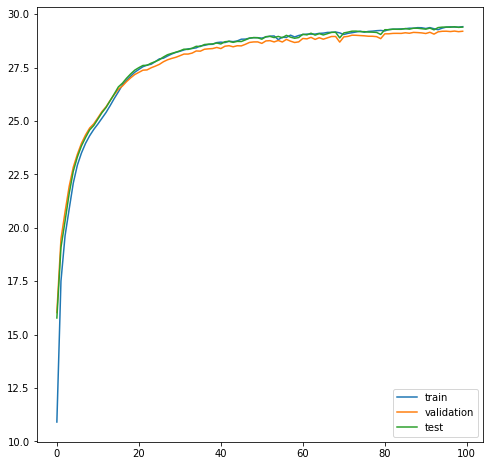

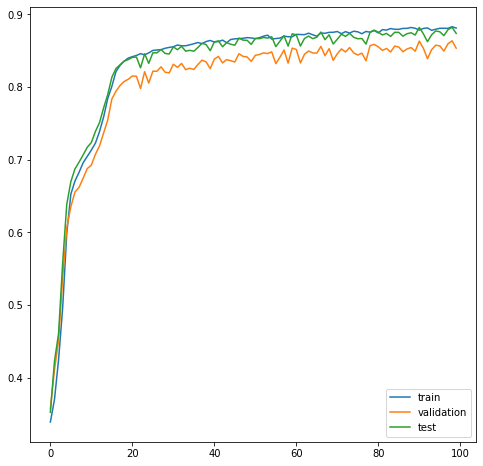

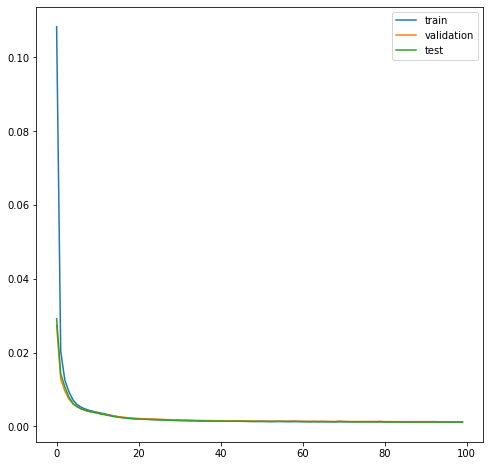

In [ ]:
class MetricsCallback(tf.keras.callbacks.Callback):
  def __init__(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test
    self.loss = []
    self.accuracy = []
    self.psnr = []


  def on_epoch_end(self, epoch, logs=None):
    results = model.evaluate(self.X_test, self.y_test)
    self.loss.append(results[0])
    self.accuracy.append(results[1])
    self.psnr.append(results[2])
    
def model_init_fn():
  return Autoencoder()

def optimizer_init_fn():
  learning_rate = 5e-4
  return tf.keras.optimizers.Adam(learning_rate)

def loss_init_fn():
  return tf.keras.losses.MeanSquaredError()

def PSNR(img1, img2):
  return tf.image.psnr(img1, img2, max_val=1.)

model = model_init_fn()
optimizer = optimizer_init_fn()
loss = loss_init_fn()



tab = ["gaussian", "poisson", "saltAndPepper", "speckle"]

for i in range(4):
  
  name = tab[i]
  test_data_path, train_data_path, val_data_path = loadImages(path + "test"), loadImages(path + "train"), loadImages(path + "val")

  test_data_path, train_data_path, val_data_path = procesImages(test_data_path), procesImages(train_data_path), procesImages(val_data_path)

  test_data, train_data, val_data = createDataSet(test_data_path, name), createDataSet(train_data_path, name), createDataSet(val_data_path, name)

  X_train, y_train, X_val, y_val, X_test, y_test = load_data(test_data, train_data, val_data)


  del test_data_path, train_data_path, val_data_path
  del test_data, train_data, val_data

  metrics_callback = MetricsCallback(X_test, y_test)
  model.compile(optimizer, 
                loss,
                metrics = [
                          'accuracy',
                          PSNR
                          ]
                )

  history = model.fit(X_train, y_train,
                  epochs=100,
                  batch_size=10,
                  shuffle=True,
                  validation_data=(X_val, y_val),
                  callbacks = [metrics_callback]
                  )

  decoded_imgs = model.predict(X_test)
  decoded_imgs = tf.clip_by_value(decoded_imgs, 0.0, 1.0)

  img = np.uint8(X_test[13] * 255)
  cv2.imwrite(name+'_noisy.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

  img = np.uint8(decoded_imgs[13] * 255)
  cv2.imwrite(name+'_denoised.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


  plt.figure(figsize=(8,8))
  plt.plot(history.history['PSNR'], label="train")
  plt.plot(history.history['val_PSNR'], label="validation")
  plt.plot(metrics_callback.psnr, label="test")
  plt.legend(loc='lower right')
  plt.savefig(name+'_PSNR.png')

  plt.figure(figsize=(8,8))
  plt.plot(history.history['accuracy'], label="train")
  plt.plot(history.history['val_accuracy'], label="validation")
  plt.plot(metrics_callback.accuracy, label="test")
  plt.legend(loc='lower right')
  plt.savefig(name+'_accuracy.png')

  plt.figure(figsize=(8,8))
  plt.plot(history.history['loss'], label="train")
  plt.plot(history.history['val_loss'], label="validation")
  plt.plot(metrics_callback.loss, label="test")
  plt.legend(loc='upper right')
  plt.savefig(name+'_loss.png')